In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  

In [2]:
!ls ../faci/
key_pts_frame = pd.read_csv('../faci/training.csv')
key_pts_frame.keys

IdLookupTable.csv     test.csv	training.csv
SampleSubmission.csv  test.zip	training.zip


<bound method NDFrame.keys of       left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0             66.033564          39.002274           30.227008   
1             64.332936          34.970077           29.949277   
2             65.057053          34.909642           30.903789   
3             65.225739          37.261774           32.023096   
4             66.725301          39.621261           32.244810   
...                 ...                ...                 ...   
7044          67.402546          31.842551           29.746749   
7045          66.134400          38.365501           30.478626   
7046          66.690732          36.845221           31.666420   
7047          70.965082          39.853666           30.543285   
7048          66.938311          43.424510           31.096059   

      right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0              36.421678                59.582075                39.647423   
1              33.448

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


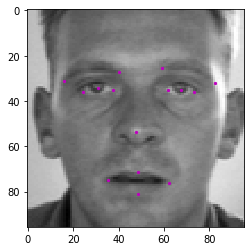

In [3]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

n=99
# key_pts_frame.describe()
image = key_pts_frame.iloc[n, -1]
key_pts = key_pts_frame.iloc[n, :-1].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)
image = np.array(image.split(),dtype=np.float).reshape(96,-1)
show_keypoints(image,key_pts)

In [4]:
csv_file='/home/a/Desktop/faci/training.csv'
key_pts_frame = pd.read_csv(csv_file)

print(np.average(key_pts_frame.describe().loc['mean']))
print(np.average(key_pts_frame.describe().loc['std']))



47.769996876423875
3.6008725339640475


In [5]:
from torch.utils.data import Dataset, DataLoader
class FacialKeypointsDataset(Dataset):

    def __init__(self, csv_file, transform=None, Train=True):
        self.key_pts_frame = pd.read_csv(csv_file)
        self.key_pts_frame = self.key_pts_frame.drop(self.key_pts_frame[self.key_pts_frame.isnull().T.any().T].index)

        split_len = int(len(self.key_pts_frame)/2)
        if Train:
            self.key_pts_frame= self.key_pts_frame[:split_len]
        else:
            self.key_pts_frame= self.key_pts_frame[split_len:]
            
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        key_pts_frame = self.key_pts_frame
        image  = np.array(key_pts_frame.iloc[idx, -1].split(),dtype=np.float).reshape((96,96))
        key_pts = key_pts_frame.iloc[idx, :-1].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        
        sample = {'image': image, 'keypoints': key_pts}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
import torch
from torchvision import transforms

class Normalize(object):
    def __call__(self, sample):
        image,key_pts = sample['image'],sample['keypoints']
        image = sample['image']/255.0
        key_pts = (key_pts - 50)/3.5
        return  {'image':image,
                'keypoints':key_pts }

class ToTensor(object):
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [7]:
data_transform = transforms.Compose([Normalize(),ToTensor()])

batch_size = 16
train_dataset = FacialKeypointsDataset(csv_file='/home/a/Desktop/faci/training.csv',transform=data_transform)
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4) 

test_dataset = FacialKeypointsDataset(csv_file='/home/a/Desktop/faci/training.csv',transform=data_transform,Train=False)
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [8]:
list(filter(lambda x: x[0]!= '_' ,dir(test_loader))),list(filter(lambda x: x[0] != '_' ,dir(test_dataset)))

(['batch_sampler',
  'batch_size',
  'collate_fn',
  'dataset',
  'dataset_kind',
  'drop_last',
  'multiprocessing_context',
  'num_workers',
  'pin_memory',
  'sampler',
  'timeout',
  'worker_init_fn'],
 ['key_pts_frame', 'transform'])

In [9]:
def net_sample_output():
    net.eval()
    for i, sample in enumerate(test_loader):
        images = sample['image']
        key_pts = sample['keypoints']
        images = images.type(torch.FloatTensor)
        output_pts = net(images)
        output_pts = output_pts.view(output_pts.size()[0], 15, -1)
        if i == 0:
            return images, output_pts, key_pts            

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        #96-5/1 +1 = 92  -- after maxpool = 32 filters of 1X46X46 = 32X46X46 
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.dropout1 = nn.Dropout(p=0.6)
        
        self.pool = nn.MaxPool2d(2, 2)
    
        #  output size = (W-F)/S +1  = 46-3/1 +1 = 44-->after maxpool = 64X22X22
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout2 = nn.Dropout(p=0.7)
        #  output size = (W-F)/S +1  = 22-3/1 +1 = 20-->after maxpool = 128X10X10

        self.conv3 = nn.Conv2d(64, 128, 3)
        self.dropout3 = nn.Dropout(p=0.5)
        
        
        self.fc1 = nn.Linear(128*10*10, 10*30)
        self.fc1_drop = nn.Dropout(p=0.4)
        
        
        self.fc2 = nn.Linear(10*30, 30)
        
        
    def forward(self, x):
        x = self.dropout1(self.pool(F.relu(self.conv1(x))))
        x = self.dropout2(self.pool(F.relu(self.conv2(x)))) 
        x = self.dropout3(self.pool(F.elu(self.conv3(x)))) 
        x = x.view(x.size(0), -1)
        x = F.elu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        return x

In [11]:
net = Net()
test_images, test_outputs, gt_pts = net_sample_output()

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


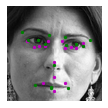

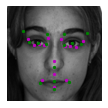

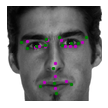

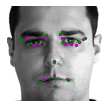

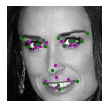

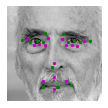

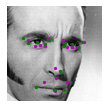

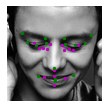

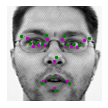

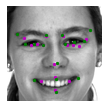

In [19]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)
        import pdb
#         pdb.set_trace()
        image = test_images[i].numpy() 
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
 
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
         
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]*3.5+50
         
        show_all_keypoints(np.squeeze(image), predicted_key_pts*3.5+50, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

visualize_output(test_images, test_outputs, gt_pts)

In [14]:
import torch.optim as optim
criterion = nn.modules.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
model_dir = 'saved_models/'
model_name = 'keypoints_detection.pt'

def train_net(n_epochs,pre_train = False):

    net.train()
    if pre_train:
        net.load_state_dict(torch.load(model_dir+model_name))
    
    for epoch in range(n_epochs):  
        running_loss = 0.0

      
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            output_pts = net(images)

            loss = criterion(output_pts, key_pts)

            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')
    
from datetime import datetime
n_epochs = 10
start = datetime.now()
train_net(n_epochs)
end = datetime.now()
elapsed_time = end - start
print('Elapse Time:{}\nAverage Time:{}'.format(elapsed_time, elapsed_time/ n_epochs))
 

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 1, Batch: 10, Avg. Loss: 1.880558431148529
Epoch: 1, Batch: 20, Avg. Loss: 0.7826722443103791
Epoch: 1, Batch: 30, Avg. Loss: 0.5622686564922332
Epoch: 1, Batch: 40, Avg. Loss: 0.45402525961399076
Epoch: 1, Batch: 50, Avg. Loss: 0.4056419789791107
Epoch: 1, Batch: 60, Avg. Loss: 0.40099427103996277


/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 2, Batch: 10, Avg. Loss: 0.37032171189785
Epoch: 2, Batch: 20, Avg. Loss: 0.36850132048130035
Epoch: 2, Batch: 30, Avg. Loss: 0.3299398571252823
Epoch: 2, Batch: 40, Avg. Loss: 0.3270369917154312
Epoch: 2, Batch: 50, Avg. Loss: 0.3516352355480194
Epoch: 2, Batch: 60, Avg. Loss: 0.3290972143411636


/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 3, Batch: 10, Avg. Loss: 0.32564111053943634
Epoch: 3, Batch: 20, Avg. Loss: 0.33128859996795657
Epoch: 3, Batch: 30, Avg. Loss: 0.3212684392929077
Epoch: 3, Batch: 40, Avg. Loss: 0.3408762186765671
Epoch: 3, Batch: 50, Avg. Loss: 0.30594751983880997
Epoch: 3, Batch: 60, Avg. Loss: 0.30436645448207855


/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 4, Batch: 10, Avg. Loss: 0.3235412955284119
Epoch: 4, Batch: 20, Avg. Loss: 0.298354709148407
Epoch: 4, Batch: 30, Avg. Loss: 0.3062993764877319
Epoch: 4, Batch: 40, Avg. Loss: 0.30153419971466067
Epoch: 4, Batch: 50, Avg. Loss: 0.2798631489276886
Epoch: 4, Batch: 60, Avg. Loss: 0.2822201281785965


/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 5, Batch: 10, Avg. Loss: 0.27256308645009997
Epoch: 5, Batch: 20, Avg. Loss: 0.2833282664418221
Epoch: 5, Batch: 30, Avg. Loss: 0.25676762908697126
Epoch: 5, Batch: 40, Avg. Loss: 0.2629534170031548
Epoch: 5, Batch: 50, Avg. Loss: 0.26073677837848663
Epoch: 5, Batch: 60, Avg. Loss: 0.26844543814659116


/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 6, Batch: 10, Avg. Loss: 0.22509707659482955
Epoch: 6, Batch: 20, Avg. Loss: 0.23332058638334274
Epoch: 6, Batch: 30, Avg. Loss: 0.2303748294711113
Epoch: 6, Batch: 40, Avg. Loss: 0.2238641306757927
Epoch: 6, Batch: 50, Avg. Loss: 0.2595064640045166
Epoch: 6, Batch: 60, Avg. Loss: 0.250395143032074


/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 7, Batch: 10, Avg. Loss: 0.21653313636779786
Epoch: 7, Batch: 20, Avg. Loss: 0.20253079980611802
Epoch: 7, Batch: 30, Avg. Loss: 0.22992889434099198
Epoch: 7, Batch: 40, Avg. Loss: 0.21402048021554948
Epoch: 7, Batch: 50, Avg. Loss: 0.22308850288391113
Epoch: 7, Batch: 60, Avg. Loss: 0.21121986210346222


/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 8, Batch: 10, Avg. Loss: 0.19963300228118896
Epoch: 8, Batch: 20, Avg. Loss: 0.2074640229344368
Epoch: 8, Batch: 30, Avg. Loss: 0.2101823791861534
Epoch: 8, Batch: 40, Avg. Loss: 0.1833884224295616
Epoch: 8, Batch: 50, Avg. Loss: 0.17570796459913254
Epoch: 8, Batch: 60, Avg. Loss: 0.18450071960687636


/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 9, Batch: 10, Avg. Loss: 0.17934290021657945
Epoch: 9, Batch: 20, Avg. Loss: 0.18744658529758454
Epoch: 9, Batch: 30, Avg. Loss: 0.18776988387107849
Epoch: 9, Batch: 40, Avg. Loss: 0.19483949095010758
Epoch: 9, Batch: 50, Avg. Loss: 0.1822850711643696
Epoch: 9, Batch: 60, Avg. Loss: 0.1805034652352333


/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 10, Batch: 10, Avg. Loss: 0.18178415596485137
Epoch: 10, Batch: 20, Avg. Loss: 0.17255271524190902
Epoch: 10, Batch: 30, Avg. Loss: 0.1735147699713707
Epoch: 10, Batch: 40, Avg. Loss: 0.1689958766102791
Epoch: 10, Batch: 50, Avg. Loss: 0.18065982609987258
Epoch: 10, Batch: 60, Avg. Loss: 0.18115561753511428
Finished Training
Elapse Time:0:01:43.238717
Average Time:0:00:10.323872


In [15]:
torch.save(net.state_dict(), model_dir+model_name)



/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


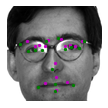

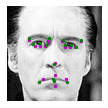

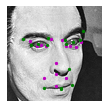

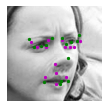

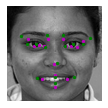

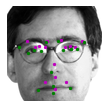

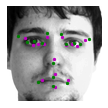

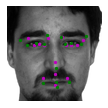

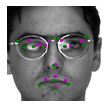

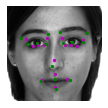

In [20]:
test_images, test_outputs, gt_pts = net_sample_output() 
visualize_output(test_images, test_outputs, gt_pts)

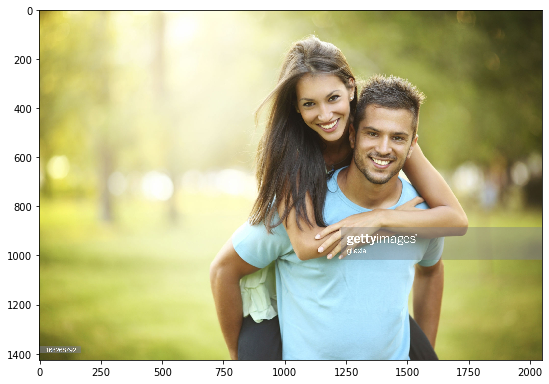

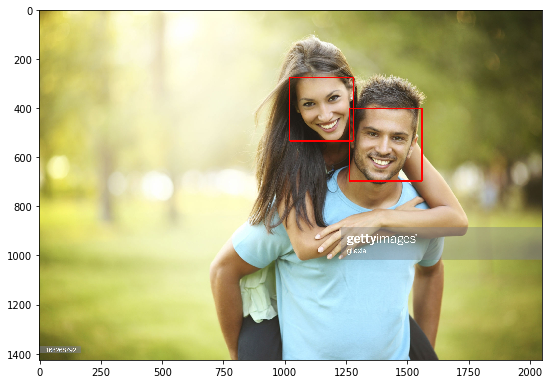

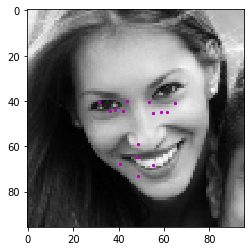

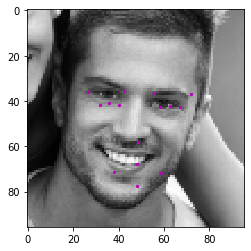

In [17]:
import cv2
image = cv2.imread('/home/a/Desktop/gettyimg.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


fig = plt.figure(figsize=(9,9))
plt.imshow(image)

face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(image, 1.2, 2)
image_with_detections = image.copy()

for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 
fig = plt.figure(figsize=(9,9))
plt.imshow(image_with_detections)
net=Net()
net.load_state_dict(torch.load(model_dir+model_name))
net.eval()
image_copy = np.copy(image)

for (x,y,w,h) in faces:
    plt.figure()
    roi = image_copy[max(y - 45, 0):min(y + h + 45, image.shape[0]), max(x - 45, 0):min(x + w + 45, image.shape[1])]
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    gray = gray / 255.0
    resized = cv2.resize(gray, (96, 96))
    ## Reshape (H x W x C) into a torch shape (C x H x W)
    if(len(resized.shape) == 2):
        resized = resized.reshape(1, resized.shape[0], resized.shape[1], 1)
    resized = resized.transpose((0, 3, 1, 2))
    image_tensor = torch.from_numpy(resized).type(torch.FloatTensor)
    pts = net(image_tensor)
    pts = pts.view(pts.size()[0], 15, -1)[0].data.cpu().numpy() 
    plt.imshow(resized[0, 0, :, :], cmap='gray')
    plt.scatter(pts[:, 0]*3.5+50, pts[:, 1]*3.5+50, s=20, marker='.', c='m')
    plt.show()

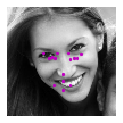

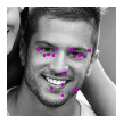

In [21]:
for (x,y,w,h) in faces:
    plt.figure(figsize=(5,2))
    roi = image_copy[max(y - 45, 0):min(y + h + 45, image.shape[0]), max(x - 45, 0):min(x + w + 45, image.shape[1])]
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    gray = gray / 255.0
    resized = cv2.resize(gray, (96, 96))
    ## Reshape (H x W x C) into a torch shape (C x H x W)
    if(len(resized.shape) == 2):
        resized = resized.reshape(1, resized.shape[0], resized.shape[1], 1)
    resized = resized.transpose((0, 3, 1, 2))
    image_tensor = torch.from_numpy(resized).type(torch.FloatTensor)
    pts = net(image_tensor)
    
    resized = np.squeeze(resized) 
     
    pts = pts.view(pts.size()[0], 15, -1)[0].data.cpu().numpy() 
  
    show_all_keypoints(resized, pts*3.5+50, None)
    plt.axis('off')
    plt.show()